In [11]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
import matplotlib as mpl
import seaborn as sb

# General utils
from tqdm import tqdm
from os import path

from measurements import get_prev_or_next_frame
from sklearn import preprocessing, model_selection, feature_selection, metrics, inspection, pipeline
from sklearn import ensemble, linear_model
from skimage import io
import pyvista as pv
from trimesh import smoothing, Trimesh, proximity
from trimesh.curvature import discrete_mean_curvature_measure,sphere_ball_intersection


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
dirnames = {'R1':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R1/',
           'R2':'/Users/xies/OneDrive - Stanford/Skin/Mesa et al/W-R2/'}
all_df = []
for name,dirname in dirnames.items():
    _df = pd.read_pickle(path.join(dirname,'Mastodon/single_timepoints_dynamics_aggregated_lookback_history.pkl'))
    _df = _df.drop_duplicates().sort_index().reset_index()
    _df['Region','Meta'] = name
    _df['TrackID'] = name + '_' + _df['TrackID'].astype(str)
    _df = _df.set_index(['Frame','TrackID'])
    all_df.append(_df)

all_df = pd.concat(all_df)
all_tracks = {trackID:t for trackID,t in all_df.reset_index().groupby('TrackID')}

dataset_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/Lineage models/Dataset pickles'
all_df = pd.read_pickle(path.join(dataset_dir,f'all_df.pkl'))
basals = pd.read_pickle(path.join(dataset_dir,f'basals.pkl'))
divisions = pd.read_pickle(path.join(dataset_dir,f'divisions.pkl'))
births = pd.read_pickle(path.join(dataset_dir,f'births.pkl'))

In [13]:
# # Load adjacency maps

# adj_dir = '/Users/xies/Library/CloudStorage/OneDrive-Stanford/Skin/Mesa et al/W-R1/Mastodon/basal_connectivity_3d'
# adjDicts = [np.load(path.join(adj_dir,f'adjacenct_trackIDs_t{t}.npy'),allow_pickle=True).item()]

# Minimum distance to other turnover events

In [14]:
# Separate the regions
IDs = births.reset_index()['TrackID'].str.split('_',expand=True)
births['trackID','Meta'] = IDs[1].astype(int).values
births['Region','Meta'] = IDs[0].values

IDs = divisions.reset_index()['TrackID'].str.split('_',expand=True)
divisions['trackID','Meta'] = IDs[1].astype(int).values
divisions['Region','Meta'] = IDs[0].values
IDs = basals.reset_index()['TrackID'].str.split('_',expand=True)
basals['trackID','Meta'] = IDs[1].astype(int).values
basals['Region','Meta'] = IDs[0].values


/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_67122/2491382715.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df1['Min distance to birth or div','Measurement'] = np.nanmin(D,axis=0)
/var/folders/zp/5k1kvm9j0t19cvq8h628kr8h0000gn/T/ipykernel_67122/2491382715.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  _df2['Min distance to birth or div','Measurement'] = np.nanmin(D,axis=0)


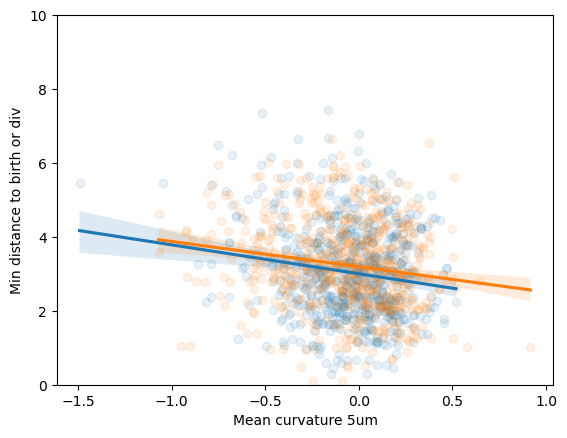

In [15]:
from scipy.spatial import distance

def calculate_distance_matrix_among_events(df, measurement_fields=[['X','Y','Z']]):
    D = distance.squareform(distance.pdist(df[['X','Y','Z']]))
    D[np.eye(len(D)) > 0] = np.nan
    return D

_df1 = births[births['Region','Meta'] == 'R1']
D = calculate_distance_matrix_among_events(_df1)
_df1['Min distance to birth or div','Measurement'] = np.nanmin(D,axis=0)

sb.regplot(_df1.droplevel(axis=1,level=1),x='Mean curvature 5um',
           y='Min distance to birth or div',scatter_kws={'alpha':0.1})

_df2 = births[births['Region','Meta'] == 'R2']
D = calculate_distance_matrix_among_events(_df2)
_df2['Min distance to birth or div','Measurement'] = np.nanmin(D,axis=0)

sb.regplot(_df2.droplevel(axis=1,level=1),x='Mean curvature 5um',
           y='Min distance to birth or div',scatter_kws={'alpha':0.1})
plt.ylim([0,10])

_df = pd.concat((_df1,_df2))


In [16]:
import statsmodels.formula.api as smf

model = smf.ols(data = _df.rename(columns={'Min distance to birth or div':'min_dist',
                                  'Mean curvature 5um':'mean_curv'}),
        formula = 'min_dist ~ mean_curv').fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               min_dist   R-squared:                       0.027
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     36.38
Date:                Mon, 01 Dec 2025   Prob (F-statistic):           2.10e-09
Time:                        15:42:36   Log-Likelihood:                -2139.9
No. Observations:                1333   AIC:                             4284.
Df Residuals:                    1331   BIC:                             4294.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      3.0931      0.034     91.063      0.000       3.026       3.160
mean_curv     -0.7352      0.122     -6.031      0.000      -0.974      -0.496
==============================================================================
Omnibus:                       17.373   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.659
Skew:                           0.269   Prob(JB):                     0.000146
Kurtosis:                       2.829   Cond. No.                         3.71
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Actual density measurements (# of events in 3D spheres)

np.float64(0.2220060417694862)

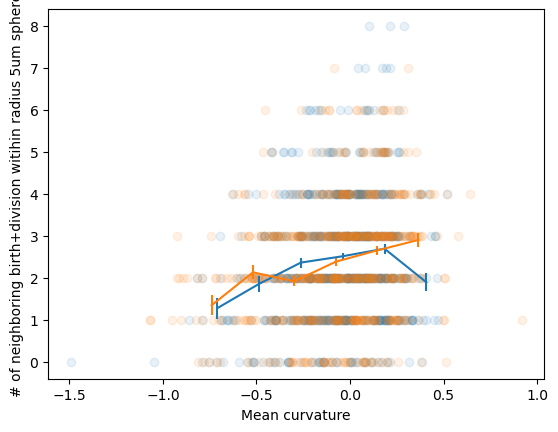

In [18]:
from basicUtils import plot_bin_means

def count_neighboring_events(D,threshold):
    return np.sum(D < threshold,axis=0)

threshold = 5

D = calculate_distance_matrix_among_events(_df1)
plt.scatter(_df1['Mean curvature 5um','Measurement'],
            count_neighboring_events(D,threshold),alpha=0.1)
plot_bin_means(_df1['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold),bin_edges=10,mean='mean')

D = calculate_distance_matrix_among_events(_df2)
plt.scatter(_df2['Mean curvature 5um','Measurement'],
            count_neighboring_events(D,threshold),alpha=0.1)
plt.xlabel('Mean curvature')
plt.ylabel('# of neighboring birth+division witihin radius 5um sphere')
plot_bin_means(_df2['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold),bin_edges=10,mean='mean')

np.corrcoef(_df2['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold))[0,1]


array([        nan, 12.90909091, 10.16666667, 13.02857143, 14.1       ,
       13.98507463, 14.51456311, 15.34090909, 14.88095238, 15.775     ,
       14.17647059,         nan,         nan,         nan])

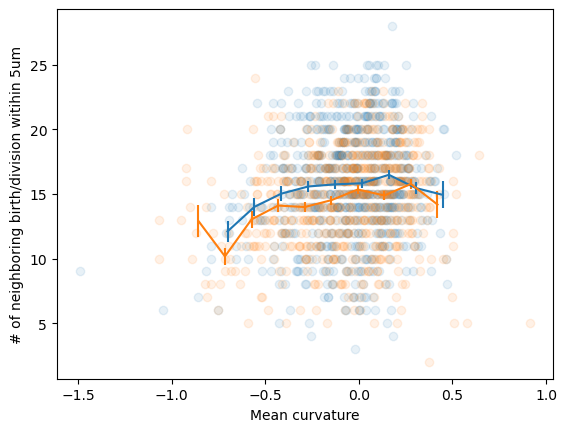

In [20]:
from basicUtils import plot_bin_means

def count_neighboring_events(D,threshold):
    return np.sum(D < threshold,axis=0)

threshold = 10
D = calculate_distance_matrix_among_events(_df1)
plt.scatter(_df1['Mean curvature 5um','Measurement'],
            count_neighboring_events(D,threshold),alpha=0.1)
plot_bin_means(_df1['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold),bin_edges=15,mean='mean')

D = calculate_distance_matrix_among_events(_df2)
plt.scatter(_df2['Mean curvature 5um','Measurement'],count_neighboring_events(D,threshold),alpha=0.1)
plt.xlabel('Mean curvature')
plt.ylabel('# of neighboring birth/division witihin 5um')
plot_bin_means(_df2['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold),bin_edges=15,mean='mean')

np.float64(0.15983449339123756)

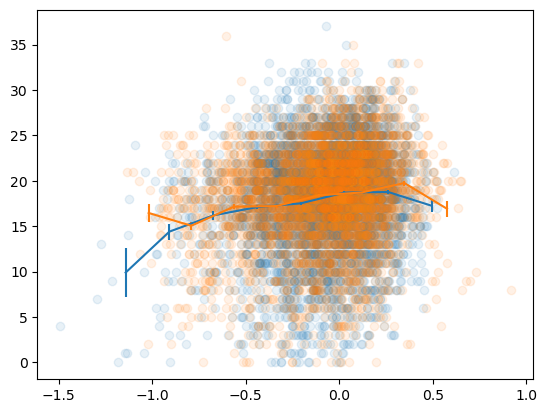

In [21]:
threshold = 5

basals_r1 = basals[basals['Region','Meta'] == 'R1']
basals_r2 = basals[basals['Region','Meta'] == 'R2']
D = calculate_distance_matrix_among_events(basals_r1)
plt.scatter(basals_r1['Mean curvature 5um','Measurement'],count_neighboring_events(D,threshold),alpha=0.1)
plot_bin_means(basals_r1['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold),bin_edges=10,mean='mean')

# plt.figure()
D = calculate_distance_matrix_among_events(basals_r2)
plt.scatter(basals_r2['Mean curvature 5um','Measurement'],count_neighboring_events(D,threshold),alpha=0.1)
plot_bin_means(basals_r2['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold),bin_edges=10,mean='mean')
np.corrcoef(basals_r2['Mean curvature 5um','Measurement'].values,count_neighboring_events(D,threshold))[0,1]
